In [15]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

# Zadanie

Dysponujesz danymi z portalu Our World in Data dotyczącymi:
- Pierwotnej konsumpcji energii
- Emisji CO2 z poszczególnych lat dla różnych krajów

## Część 1: Plik CSV
Utwórz plik CSV zawierający połączone dane dla Polski:
- konsumpcja energii pierwotnej
- emisja CO2
- dane z poszczególnych lat

## Część 2: Plik Excel
Stwórz plik Excel z osobnymi zakładkami dla każdego kraju:
- UE
- USA
- Chiny
- Indie

Każda zakładka powinna zawierać dane o konsumpcji energii i emisji CO2.

## Część 3: Baza danych SQLite
Utwórz bazę danych SQLite z tabelą zawierającą:
- kraj
- rok
- emisja CO2
- konsumpcja energii

Dane powinny obejmować: Polskę, Niemcy i Hiszpanię.

## Część 4: Analiza i wizualizacja
Na podstawie danych z pliku Excel i bazy SQLite utwórz wykresy:
- emisja CO2 w zależności od roku (dla wybranego kraju)
- konsumpcja energii pierwotnej w zależności od roku (dla wybranego kraju)
- **dla chęnych szukanie koreacji**

In [ ]:
df_co2 = pd.read_csv("/content/co2-emissions-per-capita.csv")
df_co2.head()

,Entity,Year,Annual CO₂ emissions (per capita)
0,Afghanistan,1949,0.001992
1,Afghanistan,1950,0.010837
2,Afghanistan,1951,0.011625
3,Afghanistan,1952,0.011468
4,Afghanistan,1953,0.013123


In [ ]:
df_primary_energy = pd.read_csv("/content/primary-energy-cons.csv")
df_primary_energy.head()

,Entity,Code,Year,Primary energy consumption (TWh)
0,Afghanistan,AFG,1980,6.337187
1,Afghanistan,AFG,1981,7.289555
2,Afghanistan,AFG,1982,7.889244
3,Afghanistan,AFG,1983,9.882159
4,Afghanistan,AFG,1984,9.929878


#Częsść 1:


In [3]:

primary = pd.read_csv("primary-energy-cons.csv")
co2 = pd.read_csv("co2-emissions-per-capita.csv")

primary = primary.rename(columns={"Primary energy consumption (TWh)": "primary_twh"})
co2 = co2.rename(columns={"Annual CO₂ emissions (per capita)": "co2_per_capita"})

pl_energy = primary[primary["Entity"] == "Poland"]
pl_co2 = co2[co2["Entity"] == "Poland"]

pl_merged = pd.merge(pl_energy[["Year", "primary_twh"]],
                     pl_co2[["Year", "co2_per_capita"]],
                     on="Year", how="inner")

pl_merged.to_csv("poland_energy_co2.csv", index=False)
display(pl_merged.head())


,Year,primary_twh,co2_per_capita
0,1965,776.05330,7.893703
1,1966,791.17820,7.996349
2,1967,814.29987,8.138128
3,1968,876.36676,8.597721
4,1969,936.06604,9.076116


# Część 2

In [9]:
from openpyxl import load_workbook
from openpyxl.styles import Font
countries = ["European Union (27 countries)", "United States", "China", "India"]

with pd.ExcelWriter("energy_co2_countries.xlsx") as writer:
    for c in countries:
        df_energy = primary[primary["Entity"] == c][["Year", "primary_twh"]]
        df_co2 = co2[co2["Entity"] == c][["Year", "co2_per_capita"]]
        merged = pd.merge(df_energy, df_co2, on="Year", how="inner")
        merged.to_excel(writer, sheet_name=c.replace(" ", "_")[:30], index=False)

wb = load_workbook("energy_co2_countries.xlsx")

for c in countries:
    sheet_name = c.replace(" ", "_")[:30]
    ws = wb[sheet_name]
    ws["A1"] = c
    ws["A1"].font = Font(size=10, bold=True)
    ws.column_dimensions["A"].width = 20

wb.save("energy_co2_countries.xlsx")



# Część 3

In [11]:
import sqlite3

conn = sqlite3.connect("energy_co2.db")

countries_db = ["Poland", "Germany", "Spain"]

records = []
for c in countries_db:
    df_e = primary[primary["Entity"] == c][["Year", "primary_twh"]]
    df_c = co2[co2["Entity"] == c][["Year", "co2_per_capita"]]
    df = pd.merge(df_e, df_c, on="Year", how="inner")
    df["Entity"] = c
    records.append(df)

final_db = pd.concat(records)
final_db.to_sql("energy_data", conn, if_exists="replace", index=False)
conn.commit()
conn.close()


Część 4

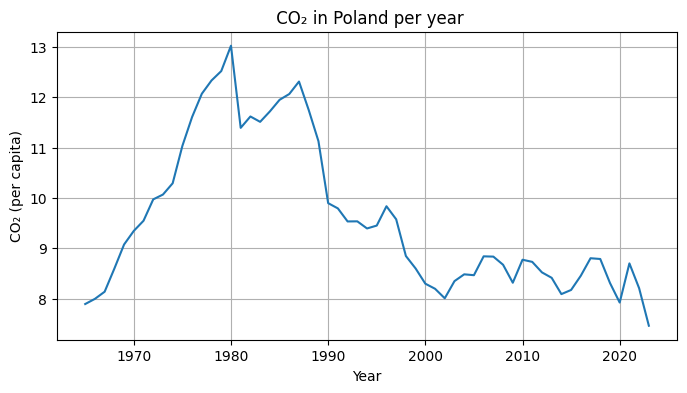

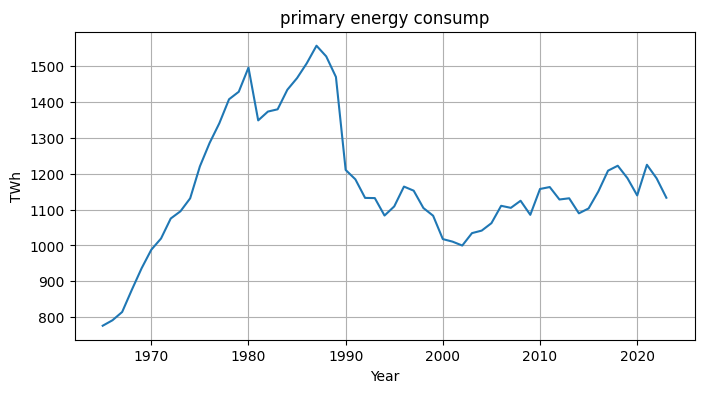

Primary energy consump and  CO₂ in Poland per year corelation  0.823


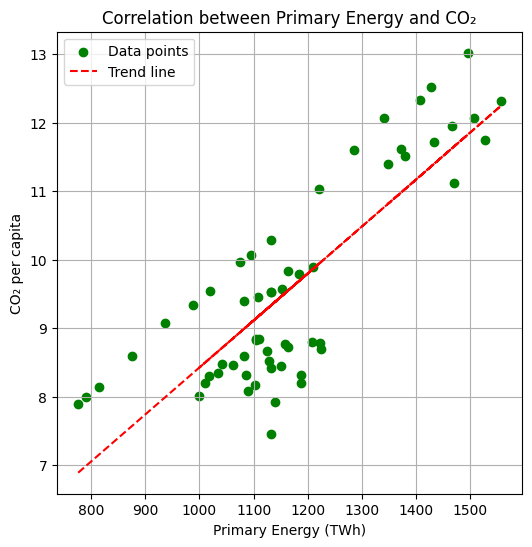

In [16]:
import matplotlib.pyplot as plt
import sqlite3

conn = sqlite3.connect("energy_co2.db")
query = "SELECT * FROM energy_data WHERE Entity='Poland';"
df = pd.read_sql(query, conn)
conn.close()

plt.figure(figsize=(8,4))
plt.plot(df["Year"], df["co2_per_capita"])
plt.title(" CO₂ in Poland per year")
plt.xlabel("Year")
plt.ylabel("CO₂ (per capita)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(df["Year"], df["primary_twh"])
plt.title("primary energy consump")
plt.xlabel("Year")
plt.ylabel("TWh")
plt.grid(True)
plt.show()

corr = df["primary_twh"].corr(df["co2_per_capita"])
print(f"Primary energy consump and  CO₂ in Poland per year corelation  {corr:.3f}")
# Scatter plot for corealation visuals
plt.figure(figsize=(6,6))
plt.scatter(df["primary_twh"], df["co2_per_capita"], color='green', label='Data points')

# trend line
m, b = np.polyfit(df["primary_twh"], df["co2_per_capita"], 1)
plt.plot(df["primary_twh"], m*df["primary_twh"] + b, color='red', linestyle='--', label='Trend line')

plt.title("Correlation between Primary Energy and CO₂")
plt.xlabel("Primary Energy (TWh)")
plt.ylabel("CO₂ per capita")
plt.legend()
plt.grid(True)
plt.show()